# Estimación de Masas Nucleares Mediante Redes Neuronales Probabilísticas y Random Forest

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import mdn

# Datos de AME(2020) y NNDC

AME(2020) data: https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt

AME(2020) artículo: https://doi.org/10.1088/1674-1137/abddaf

NNDC: https://www.nndc.bnl.gov/


In [2]:
# Base de datos AME 2020
mass = pd.read_csv("NUBASE1.csv")
mass.columns = ['AAA','ZZZi','AEl', 's', 'Mass', 'dMass']
mass['Mass'] = mass['Mass'].str.replace('#', '.0')
mass['dMass'] = mass['dMass'].str.replace('#', '.0')
mass['ZZZi'] = mass['ZZZi'].astype(str).str[:-1].astype(np.int64)
mass['AAA'] = mass['AAA']
mass = mass.sort_values('ZZZi')
mass = mass.reset_index()
mass = mass.drop('index',axis = 1)
mass = mass.drop('s', axis = 1)
mass

,AAA,ZZZi,AEl,Mass,dMass
0,1,1,1H,7288.971064,1E-05
1,2,1,2H,13135.722895,1E-05
2,3,1,3H,14949.8109,8E-05
3,7,1,7H,49140.0,1000.0
4,4,1,4H,24620,100
...,...,...,...,...,...
5837,293,117,293Ts,194430.0,780.0
5838,294,117,294Ts,196400.0,590.0
5839,294,118,294Og,199320.0,550.0
5840,293,118,293Og,198800.0,710.0


In [3]:
# Energía de primer estado excitado de NNDC
first_ex = pd.read_csv("1st_ExcitedStateEnergy.csv")
first_ex.z = first_ex.z
first_ex.n = first_ex.n
first_ex.columns = ['n','z','First']
first_ex = first_ex.sort_values('z')
first_ex['First'] = first_ex['First']/1000
first_ex

,n,z,First
0,3,1,0.310
1,4,1,3.100
2,5,1,4.100
3,6,1,15.000
4,2,2,20.210
...,...,...,...
2187,158,108,0.085
2188,159,108,0.057
2190,163,110,0.283
2189,160,110,1.130


In [6]:
# Se crea una nueva característica energía del primer estado excitado
mass['FirstExc'] = np.nan

# Se asignan los valores de la energía del primer estado excitado a los correspondientes Z y N

for i in range(len(np.array(first_ex.index))):
    
    A = first_ex.at[i,'z'] + first_ex.at[i,'n']
    FE = first_ex.at[i,'First']
    
    for j in range(len(np.array(mass.index))):
        
        if (first_ex.at[i,'z'] == mass.at[j, 'ZZZi']):
                        
            if (float(A) == float(mass.at[j, 'AAA'])):
                mass.at[j, 'FirstExc'] = FE
                break

        if first_ex.at[i,'z'] < mass.at[j, 'ZZZi']:
            break

In [7]:
# Se incluye el número de neutrones
mass['NNNi'] = mass['AAA']-mass['ZZZi']

In [8]:
# Se incluye los nucleones por fuera o faltantes de las capas N,Z = 2,8,20,18,50,82,126
mass['DeltaZ']=np.nan
mass['DeltaN']=np.nan
mass['Zshell']=np.nan
mass['Nshell']=np.nan

for i in range(len(np.array(mass.index))):
    
    Z = mass.at[i,'ZZZi']
    
    # Se llena la característica DeltaZ
    if (0 <= Z < 2):
        mass.at[i,'DeltaZ'] = min(abs(Z-0),abs(Z-2))
        
    if (2 <= Z < 8):
        mass.at[i,'DeltaZ'] = min(abs(Z-2),abs(Z-8))  

    if (8 <= Z < 20):
        mass.at[i,'DeltaZ'] = min(abs(Z-8),abs(Z-20))            

    if (20 <= Z < 28):
        mass.at[i,'DeltaZ'] = min(abs(Z-20),abs(Z-28))            

    if (28 <= Z < 50):
        mass.at[i,'DeltaZ'] = min(abs(Z-28),abs(Z-50))            

    if (50 <= Z < 82):
        mass.at[i,'DeltaZ'] = min(abs(Z-50),abs(Z-82))            

    if (82 <= Z < 126):
        mass.at[i,'DeltaZ'] = min(abs(Z-82),abs(Z-126))            
        
    if (126 <= Z ):
        mass.at[i,'DeltaZ'] = abs(Z-126)  
        
        
    N = mass.at[i,'NNNi']
        
    # Se llena la característica DeltaN
    if (0 <= N < 2):
        mass.at[i,'DeltaN'] = min(abs(N-0),abs(N-2)) 
        
    if (2 <= N < 8):
        mass.at[i,'DeltaN'] = min(abs(N-2),abs(N-8))

    if (8 <= N < 20):
        mass.at[i,'DeltaN'] = min(abs(N-8),abs(N-20))            

    if (20 <= N < 28):
        mass.at[i,'DeltaN'] = min(abs(N-20),abs(N-28))            

    if (28 <= N < 50):
        mass.at[i,'DeltaN'] = min(abs(N-28),abs(N-50))            

    if (50 <= N < 82):
        mass.at[i,'DeltaN'] = min(abs(N-50),abs(N-82))            

    if (82 <= N < 126):
        mass.at[i,'DeltaN'] = min(abs(N-82),abs(N-126))            
        
    if (126 <= N ):
        mass.at[i,'DeltaN'] = abs(N-126)            

In [9]:
# Se incluye la suma de los nucleones totales por fuera o faltantes en una capa cerrada
mass['DeltaSum'] = mass['DeltaZ'] + mass['DeltaN']

In [10]:
# Se añaden las demás características del modelo de gota líquida
mass['A^2/3']  = mass['AAA']**(2/3)
mass['Z(Z-1)/A^1/3']  = mass['ZZZi']*(mass['ZZZi']-1.0)/mass['AAA']**(1/3)
mass['(N-Z)^2/A']  = (mass['NNNi'] - mass['ZZZi'])**2/mass['AAA']
mass['ZEO'] = np.nan
mass['NEO'] = np.nan

for i in range(len(np.array(mass.index))):

    if (mass.at[i,'ZZZi']%2 == 0):
        mass.at[i,'ZEO']  = 0 
    else:
        mass.at[i,'ZEO']  = 1
        
    if (mass.at[i,'NNNi']%2 == 0):
        mass.at[i,'NEO']  = 0 
    else:
        mass.at[i,'NEO']  = 1

In [11]:
# Se guardan los datos del dataframe con 12 características a implementar
mass = mass.dropna(subset=['Mass'])
mass.reset_index()
mass.to_csv('FULLCHAR.csv', index = False)

In [6]:
massF = pd.read_csv("FULLCHAR.csv")
massF['Mass'] = massF['Mass']/1000
massF

,AAA,ZZZi,AEl,Mass,dMass,FirstExc,NNNi,DeltaZ,DeltaN,DeltaSum,A^2/3,Z(Z-1)/A^1/3,(N-Z)^2/A,ZEO,NEO
0,1,1,1H,7.288971,0.00001,NaN,0,1.0,0.0,1.0,1.000000,0.000000,1.000000,1.0,0.0
1,2,1,2H,13.135723,0.00001,NaN,1,1.0,1.0,2.0,1.587401,0.000000,0.000000,1.0,1.0
2,3,1,3H,14.949811,0.00008,NaN,2,1.0,0.0,1.0,2.080084,0.000000,0.333333,1.0,0.0
3,7,1,7H,49.140000,1000.00000,15000.0,6,1.0,2.0,3.0,3.659306,0.000000,3.571429,1.0,0.0
4,4,1,4H,24.620000,100.00000,310.0,3,1.0,1.0,2.0,2.519842,0.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,293,117,293Ts,194.430000,780.00000,NaN,176,9.0,50.0,59.0,44.114201,2043.405906,11.880546,1.0,0.0
5822,294,117,294Ts,196.400000,590.00000,NaN,177,9.0,51.0,60.0,44.214517,2041.086487,12.244898,1.0,1.0
5823,294,118,294Og,199.320000,550.00000,NaN,176,8.0,50.0,58.0,44.214517,2076.277633,11.442177,0.0,0.0
5824,293,118,293Og,198.800000,710.00000,NaN,175,8.0,49.0,57.0,44.114201,2078.637042,11.088737,0.0,1.0


#### Gráficas del déficit de masa

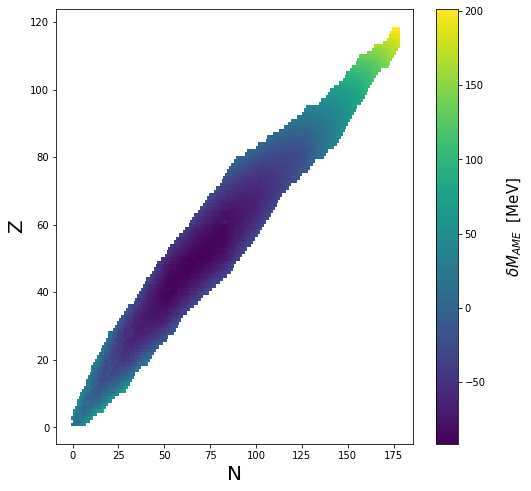

In [6]:
# Gráficas de N,Z vs deficit de mass
%matplotlib inline
fig = plt.figure(figsize = (8,8))
x = massF['NNNi'].to_numpy()
y = massF['ZZZi'].to_numpy()
cmass = massF['Mass'].to_numpy()
plt.scatter(x,y, c = cmass, marker=',', s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)

# Función para notación científica
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#Argumento de plt.colorbar: format=ticker.FuncFormatter(fmt)

plt.colorbar().set_label(label='$\delta M_{AME}$  [MeV]', size=15, labelpad=20)
plt.savefig('DeltaMedidas.png',dpi = 500)
plt.show()

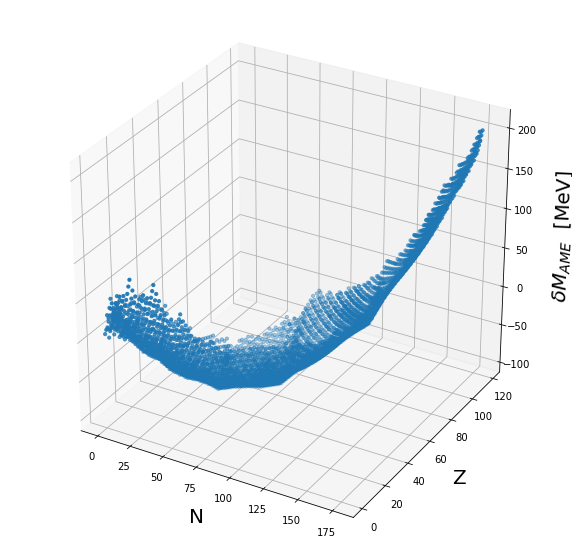

In [7]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plot = plt.figure(figsize=(10,10)).gca(projection='3d')
plot.scatter(np.array(massF['NNNi']), np.array(massF['ZZZi']), np.array(massF['Mass']), s = 10)
plot.set_xlabel('N', fontsize= 20, labelpad=10)
plot.set_ylabel('Z', fontsize= 20, labelpad=10)
plot.set_zlabel('$\delta M_{AME}$  [MeV]', fontsize= 20, labelpad=20)
plt.savefig('DeltaMedidas3D.png',dpi = 500)
plt.show()

#### Energía del primer estado excitado

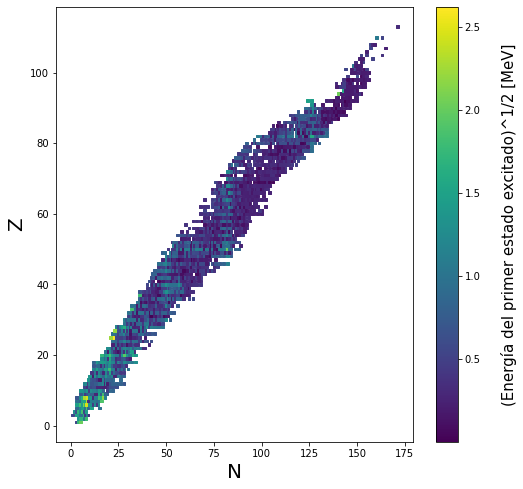

In [9]:
first_excopy = first_ex[first_ex.First != first_ex['First'].max()]
first_excopy = first_excopy[first_excopy.First != first_excopy['First'].max()]
first_excopy = first_excopy[first_excopy.First != first_excopy['First'].max()]

nn = first_excopy['n'].to_numpy()
zz = first_excopy['z'].to_numpy()
first = np.sqrt(first_excopy['First'].to_numpy())

fig = plt.figure(figsize = (8,8))
plt.scatter(nn,zz, c = first, s = 7 ,marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='(Energía del primer estado excitado)^1/2 [MeV]', size=15, labelpad=20)
plt.savefig('PrimerEExc.png',dpi = 500)
plt.show()

# SE GRAFICA LA RAÍZ CUADRADA DE LA ENERGÍA DEL PRIMER ESTADO EXCITADO Y SE ELIMINAN (SOLO PARA LA GRÁFICA) 
# LOS TRES VALORES MAYORES CON EL PROPÓSITO DE MOSTRAR MÁS CLARAMENTE LA INFORMACIÓN DE LA ESTRUCTURA QUE ESTA 
#CARACTERÍSTICA POSEE

#### Gráficas de las características $\Delta$N, $\Delta$Z y $\Delta$A = $\Delta$(N+Z)

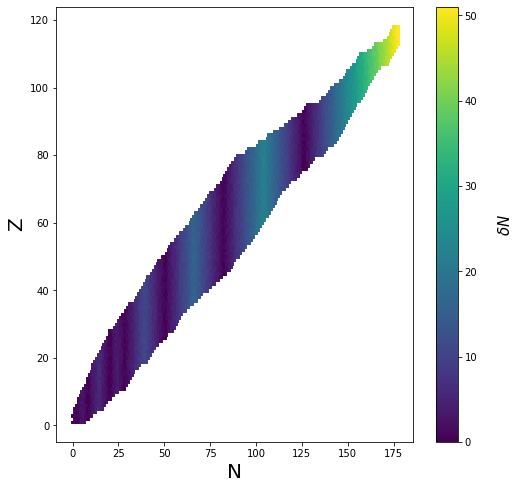

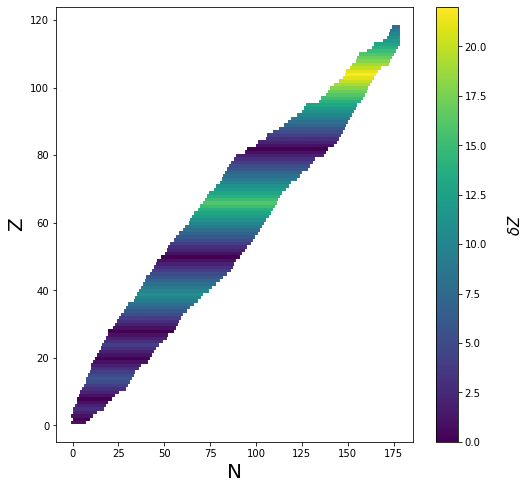

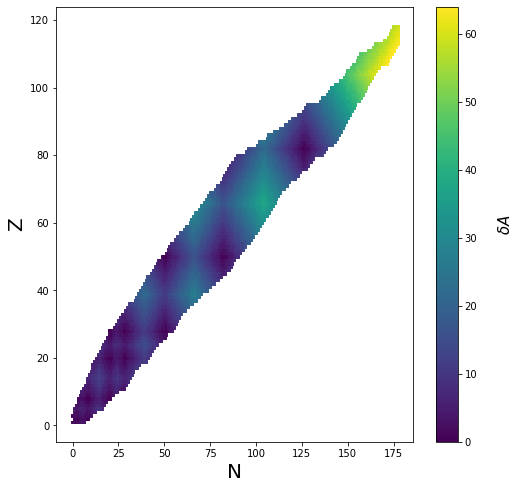

In [54]:
DN = massF['DeltaN'].to_numpy()
DZ = massF['DeltaZ'].to_numpy()
DS = massF['DeltaSum'].to_numpy()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DN ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta N$', size=15, labelpad=20)
plt.savefig('DeltaN.png',dpi = 500)
plt.show()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DZ ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta Z$', size=15, labelpad=20)
plt.savefig('DeltaZ.png',dpi = 500)
plt.show()


fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = DS ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta A$', size=15, labelpad=20)
plt.savefig('DeltaS.png',dpi = 500)
plt.show()

#### Gráficas de las características del modelo de gota líquida: términos de superficie, interacción Coulumbiana y asimetría

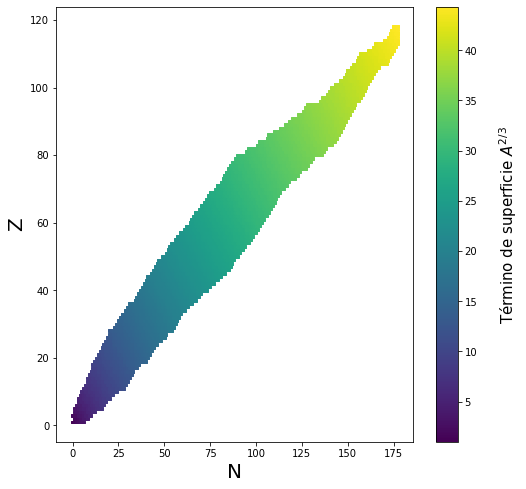

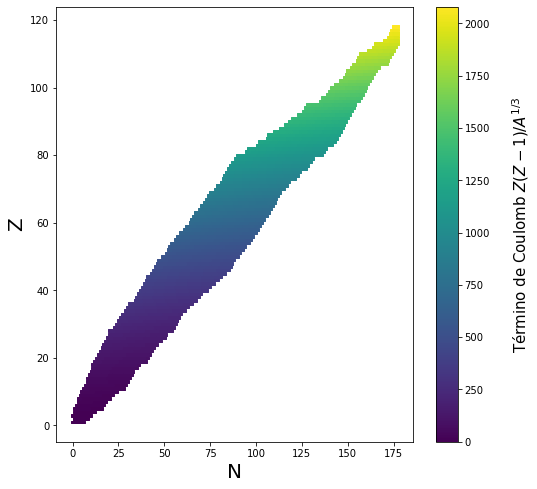

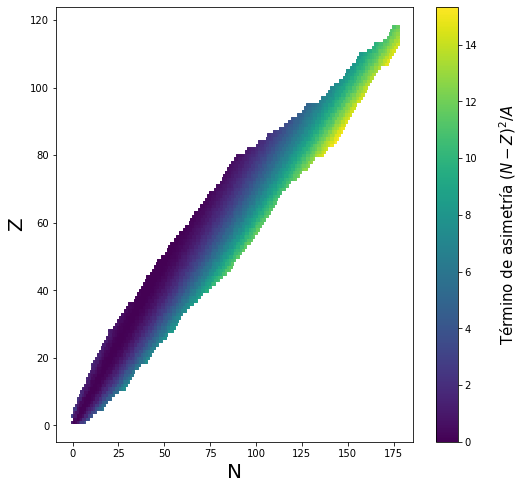

In [55]:
SURF = massF['A^2/3'].to_numpy()
COUL = massF['Z(Z-1)/A^1/3'].to_numpy()
SYMM = massF['(N-Z)^2/A'].to_numpy()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = SURF ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='Término de superficie $A^{2/3}$', size=15, labelpad=20)
plt.savefig('A23.png',dpi = 500)
plt.show()

fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = COUL ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='Término de Coulomb $Z(Z-1)/A^{1/3}$', size=15, labelpad=20)
plt.savefig('Coulomb.png',dpi = 500)
plt.show()


fig = plt.figure(figsize = (8,8))
plt.scatter(x,y, c = SYMM ,marker=',',s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='Término de asimetría $(N-Z)^2/A$', size=15, labelpad=20)
plt.savefig('Asymm.png',dpi = 500)
plt.show()

In [4]:
# Raíz cuadrático media del modelo para calcular la bondad de ajuste
def RMS(Medidas,Prediccion):
    M = np.array(Medidas)
    P = np.array(Prediccion)
    return (sum((M-P)**2)/len(P))**(0.5)  

# Modelos M12 y M11

## M12
Datos de déficit de masas con 12 características

In [7]:
# Datos M12: Ajuste de déficit de masas con 12 características
massF12 = massF
massF12 = massF12.dropna(subset=['FirstExc'])
massF12 = massF12.dropna(subset=['Mass'])

# Se separan los datos de test y de train
from sklearn.model_selection import train_test_split
massF12train, massF12test, p, q = train_test_split(massF12, massF12['Mass'], test_size=0.2, random_state=42)
    
# Arreglo con los datos. Características por filas y datos por columnas
X12TR = massF12train[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
X12TE = massF12test[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'FirstExc', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()

# Se normalizan los datos
#X12 = X12.transpose()
#for i in range(X12.shape[0]):
#    X12[i] = (X12[i]-min(X12[i]))/(max(X12[i])-min(X12[i]))
#X12 = X12.transpose()

print('\nDatos de entrenamiento normalizados 12 características:\n\n')
print('X =',X12TR, '\n\n Dimensiones:', X12TR.shape)

# Masas entrenamiento
Y12TR = massF12train['Mass'].to_numpy()
#Y12 = (Y12-min(Y12))/(max(Y12)-min(Y12))
Y12TR = Y12TR.reshape(np.shape(X12TR)[0],-1)
print('\n\nY =',Y12TR, '\n\n Dimensiones:', Y12TR.shape)


print('\nDatos de test normalizados 12 características:\n\n')
print('X =',X12TE, '\n\n Dimensiones:', X12TE.shape)

# Masas test
Y12TE = massF12test['Mass'].to_numpy()
#Y12 = (Y12-min(Y12))/(max(Y12)-min(Y12))
Y12TE = Y12TE.reshape(np.shape(X12TE)[0],-1)
print('\n\nY =',Y12TE, '\n\n Dimensiones:', Y12TE.shape)


Datos de entrenamiento normalizados 12 características:


X = [[ 35.  14.  21. ...   6.   1.   7.]
 [238.  95. 143. ...  13.  17.  30.]
 [156.  61.  95. ...  11.  13.  24.]
 ...
 [133.  55.  78. ...   5.   4.   9.]
 [133.  62.  71. ...  12.  11.  23.]
 [104.  46.  58. ...   4.   8.  12.]] 

 Dimensiones: (1752, 12)


Y = [[-14.39    ]
 [ 48.42    ]
 [-64.1668  ]
 ...
 [-88.070943]
 [-57.11    ]
 [-89.3951  ]] 

 Dimensiones: (1752, 1)

Datos de test normalizados 12 características:


X = [[ 49.  26.  23. ...   2.   3.   5.]
 [ 89.  38.  51. ...  10.   1.  11.]
 [162.  76.  86. ...   6.   4.  10.]
 ...
 [147.  57.  90. ...   7.   8.  15.]
 [135.  54.  81. ...   4.   1.   5.]
 [209.  88. 121. ...   6.   5.  11.]] 

 Dimensiones: (439, 12)


Y = [[-2.4751000e+01]
 [-8.6209030e+01]
 [-1.4500000e+01]
 [-2.9800200e+01]
 [-6.0570000e+01]
 [-3.7820000e+00]
 [-4.9411900e+01]
 [-4.4504000e+01]
 [ 1.6840000e+01]
 [ 3.1290000e+00]
 [-9.8800000e-01]
 [ 1.2416500e+01]
 [-7.0740000e+01]
 [-6.6105000

#### Gráfica de datos de trainig y entrenamiento para el modelo M12

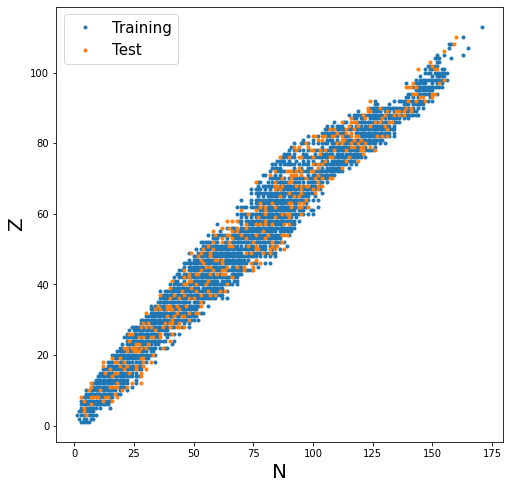

In [56]:
fig = plt.figure(figsize = (8,8))
plt.plot(X12TR[:,2],X12TR[:,1], '.', label = 'Training')
plt.plot(X12TE[:,2],X12TE[:,1], '.', label = 'Test')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.legend(fontsize=15)
plt.savefig('M12TT.png',dpi = 500)
plt.show()

## M11
Datos de déficit de masas con 11 características. Eliminando la energía del primer estado excitado

In [31]:
# Datos M11: Ajuste de déficit de masas con 12 características

massF11=massF
massF11 = massF11.drop(columns=['FirstExc'])
massF11 = massF11.dropna(subset=['Mass'])

# Arreglo con los datos. Características por filas y datos por columnas
X11 = massF11[['AAA','ZZZi', 'NNNi', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()

# Se normalizan los datos
#X11 = X11.transpose()
#for i in range(X11.shape[0]):
#    X11[i] = (X11[i]-min(X11[i]))/(max(X11[i])-min(X11[i]))
#X11 = X11.transpose()

print('\nDatos de entrenamiento normalizados 11 características:\n\n')
print('X =',X11, '\n\n Dimensiones:', X11.shape)

# Masas
Y11 = massF11['Mass'].to_numpy()
#Y11 = (Y11-min(Y11))/(max(Y11)-min(Y11))
Y11 = Y11.reshape(5826,-1)
print('\n\nY =',Y11, '\n\n Dimensiones:', Y11.shape)


Datos de entrenamiento normalizados 11 características:


X = [[  1.   1.   0. ...   1.   0.   1.]
 [  2.   1.   1. ...   1.   1.   2.]
 [  3.   1.   2. ...   1.   0.   1.]
 ...
 [294. 118. 176. ...   8.  50.  58.]
 [293. 118. 175. ...   8.  49.  57.]
 [295. 118. 177. ...   8.  51.  59.]] 

 Dimensiones: (5826, 11)


Y = [[  7.28897106]
 [ 13.1357229 ]
 [ 14.9498109 ]
 ...
 [199.32      ]
 [198.8       ]
 [201.37      ]] 

 Dimensiones: (5826, 1)


### Datos de test FRDM(2012) para el modelo M11

FRDM(2012) data: https://t2.lanl.gov/nis/molleretal/publications/ADNDT-FRDM2012.html

FRDM(2012) artículo: https://arxiv.org/pdf/1508.06294.pdf

In [89]:
# Datos de test
test = pd.read_csv('FRDM2012.csv')
test.columns = ['Z','N','A','MthFL']
test

,Z,N,A,MthFL
0,8,8,16,-5.15
1,8,9,17,-1.49
2,8,10,18,-2.81
3,8,11,19,2.15
4,8,12,20,2.19
...,...,...,...,...
9313,135,201,336,349.30
9314,135,202,337,349.90
9315,135,203,338,351.39
9316,135,204,339,352.48


In [42]:
# Se eliminan los datos coincidentes con los de AME2020

for i in range(len(np.array(test.index))):
#for i in range(0,10):
   
    for j in range(len(np.array(massF11.index))):
    #for j in range(0,10):
        
        if (massF11.at[j,'ZZZi'] == test.at[i, 'Z']):
                        
            if (massF11.at[j,'NNNi'] == test.at[i, 'N']):
                
                test = test.drop([i])
                break

In [16]:
test = test.reset_index()

In [49]:
# Se incluye los nucleones por fuera o faltantes de las capas N,Z = 2,8,20,18,50,82,126
test['DeltaZ']=np.nan
test['DeltaN']=np.nan

for i in range(len(np.array(test.index))):
    
    Z = test.at[i,'Z']
    
    # Se llena la característica DeltaZ
    if (0 <= Z < 2):
        test.at[i,'DeltaZ'] = min(abs(Z-0),abs(Z-2))
        
    if (2 <= Z < 8):
        test.at[i,'DeltaZ'] = min(abs(Z-2),abs(Z-8))  

    if (8 <= Z < 20):
        test.at[i,'DeltaZ'] = min(abs(Z-8),abs(Z-20))            

    if (20 <= Z < 28):
        test.at[i,'DeltaZ'] = min(abs(Z-20),abs(Z-28))            

    if (28 <= Z < 50):
        test.at[i,'DeltaZ'] = min(abs(Z-28),abs(Z-50))            

    if (50 <= Z < 82):
        test.at[i,'DeltaZ'] = min(abs(Z-50),abs(Z-82))            

    if (82 <= Z < 126):
        test.at[i,'DeltaZ'] = min(abs(Z-82),abs(Z-126))            
        
    if (126 <= Z ):
        test.at[i,'DeltaZ'] = abs(Z-126)  
        
        
    N = test.at[i,'N']
        
    # Se llena la característica DeltaN
    if (0 <= N < 2):
        test.at[i,'DeltaN'] = min(abs(N-0),abs(N-2)) 
        
    if (2 <= N < 8):
        test.at[i,'DeltaN'] = min(abs(N-2),abs(N-8))

    if (8 <= N < 20):
        test.at[i,'DeltaN'] = min(abs(N-8),abs(N-20))            

    if (20 <= N < 28):
        test.at[i,'DeltaN'] = min(abs(N-20),abs(N-28))            

    if (28 <= N < 50):
        test.at[i,'DeltaN'] = min(abs(N-28),abs(N-50))            

    if (50 <= N < 82):
        test.at[i,'DeltaN'] = min(abs(N-50),abs(N-82))            

    if (82 <= N < 126):
        test.at[i,'DeltaN'] = min(abs(N-82),abs(N-126))            
        
    if (126 <= N ):
        test.at[i,'DeltaN'] = abs(N-126)  
        
test['DeltaSum'] = test['DeltaZ'] + test['DeltaN']

# Se añaden las demás características del modelo de gota líquida
test['A^2/3']  = test['A']**(2/3)
test['Z(Z-1)/A^1/3']  = test['Z']*(test['Z']-1.0)/test['A']**(1/3)
test['(N-Z)^2/A']  = (test['N'] - test['Z'])**2/test['A']
test['ZEO'] = np.nan
test['NEO'] = np.nan

for i in range(len(np.array(test.index))):

    if (test.at[i,'Z']%2 == 0):
        test.at[i,'ZEO']  = 0 
    else:
        test.at[i,'ZEO']  = 1
        
    if (test.at[i,'N']%2 == 0):
        test.at[i,'NEO']  = 0 
    else:
        test.at[i,'NEO']  = 1

In [50]:
# Se guardan los datos de test
test.to_csv('TESTDATA.csv', index = False)

In [27]:
# Dataframe con los datos de entrenamiento
Test = pd.read_csv("TESTDATA.csv")
Test

,index,Z,N,A,MthFL,DeltaZ,DeltaN,DeltaSum,A^2/3,Z(Z-1)/A^1/3,(N-Z)^2/A,ZEO,NEO
0,13,8,21,29,63.89,0.0,1.0,1.0,9.439131,18.227287,5.827586,0.0,1.0
1,14,8,22,30,70.76,0.0,2.0,2.0,9.654894,18.022469,6.533333,0.0,0.0
2,15,8,23,31,81.50,0.0,3.0,3.0,9.868272,17.826557,7.258065,0.0,1.0
3,16,8,24,32,89.61,0.0,4.0,4.0,10.079368,17.638895,8.000000,0.0,0.0
4,17,8,25,33,103.64,0.0,3.0,3.0,10.288276,17.458893,8.757576,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5857,9313,135,201,336,349.30,9.0,75.0,84.0,48.331045,2602.108938,12.964286,1.0,1.0
5858,9314,135,202,337,349.90,9.0,76.0,85.0,48.426892,2599.532590,13.320475,1.0,0.0
5859,9315,135,203,338,351.39,9.0,77.0,86.0,48.522645,2596.966416,13.680473,1.0,1.0
5860,9316,135,204,339,352.48,9.0,78.0,87.0,48.618303,2594.410345,14.044248,1.0,0.0


In [28]:
# Arreglo con los datos. Características por filas y datos por columnas
XT = Test[['A','Z', 'N', 'A^2/3', 'Z(Z-1)/A^1/3', '(N-Z)^2/A', 'ZEO', 'NEO', 'DeltaZ', 'DeltaN', 'DeltaSum']].to_numpy()
print('\nDatos de test:\n\n')
print('X =',XT, '\n\n Dimensiones:', XT.shape)
YT = Test['MthFL'].to_numpy()
print('\n\nY =',YT, '\n\n Dimensiones:', YT.shape)


Datos de test:


X = [[ 29.   8.  21. ...   0.   1.   1.]
 [ 30.   8.  22. ...   0.   2.   2.]
 [ 31.   8.  23. ...   0.   3.   3.]
 ...
 [338. 135. 203. ...   9.  77.  86.]
 [339. 135. 204. ...   9.  78.  87.]
 [339. 136. 203. ...  10.  77.  87.]] 

 Dimensiones: (5862, 11)


Y = [ 63.89  70.76  81.5  ... 351.39 352.48 358.58] 

 Dimensiones: (5862,)


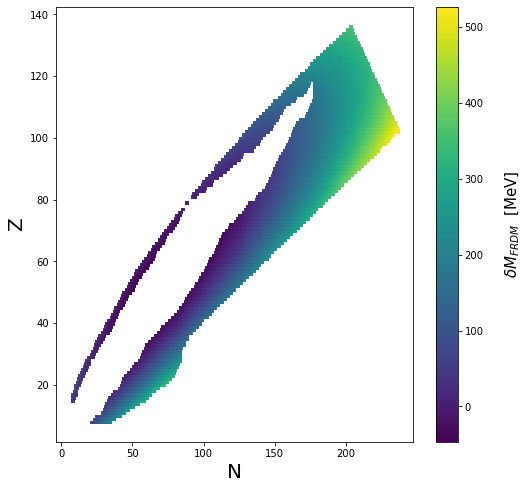

In [29]:
# Gráficas de N,Z vs deficit de mass
fig = plt.figure(figsize = (8,8))
#plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = np.concatenate((Y11,YT)), marker=',', s=7)
plt.scatter(XT[:,2],XT[:,1], c = YT, marker=',', s=7)
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)

#Argumento de plt.colorbar: format=ticker.FuncFormatter(fmt)
plt.colorbar().set_label(label='$\delta M_{FRDM}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11T.png',dpi = 500)
plt.show()

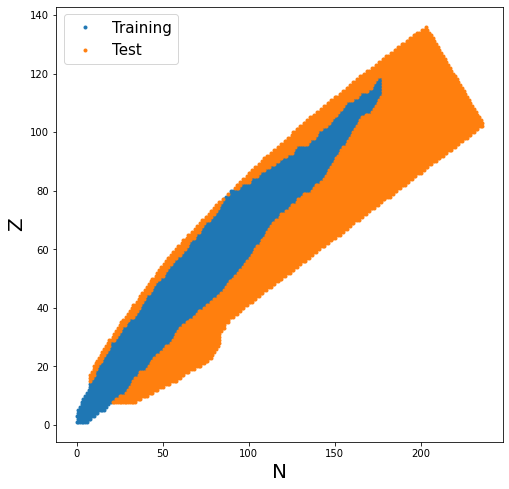

In [32]:
fig = plt.figure(figsize = (8,8))
plt.plot(X11[:,2],X11[:,1], '.', label = 'Training')
plt.plot(XT[:,2],XT[:,1], '.', label = 'Test')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.legend(fontsize=15)
plt.savefig('M11TT.png',dpi = 500)
plt.show()

# Modelo de Random Forest

# M12

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
# GridSearch
model12 = RandomForestRegressor()
hyperparam = {'n_estimators':[2000,2050]}
fitter = GridSearchCV(model12, hyperparam)

In [20]:
Y12TR1 = Y12TR.reshape(np.shape(X12TR)[0],)
fitter.fit(X12TR,Y12TR1)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [2000, 2050]})

In [21]:
fitter.best_params_

{'n_estimators': 2000}

In [22]:
# Se entrena el modelo
model12 = RandomForestRegressor(n_estimators= 2000)
Y12TR1 = Y12TR.reshape(np.shape(X12TR)[0],)
model12.fit(X12TR,Y12TR1)

RandomForestRegressor(n_estimators=2000)

In [23]:
print("Coeficiente de determinación del modelo para los datos de training: ",model12.score(X12TR, Y12TR))
print("Coeficiente de determinación del modelo para los datos de test: ",model12.score(X12TE, Y12TE))

Coeficiente de determinación del modelo para los datos de training:  0.999127172353396
Coeficiente de determinación del modelo para los datos de test:  0.9928638965168699


In [24]:
FULLDATA12 = np.concatenate((X12TR,X12TE))
FULLDATAY = np.concatenate((Y12TR,Y12TE))
FULLDATAY = FULLDATAY.reshape(2191,)
PRED = model12.predict(FULLDATA12)

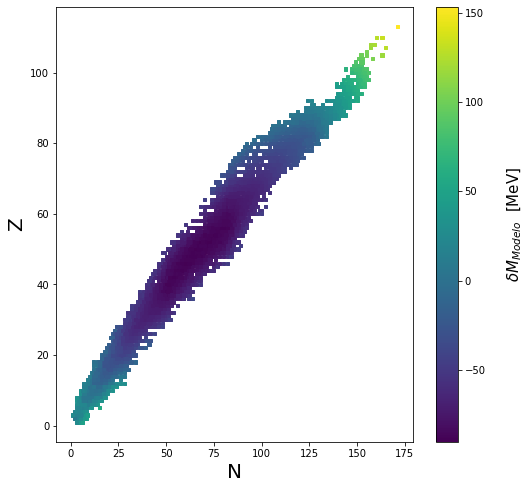

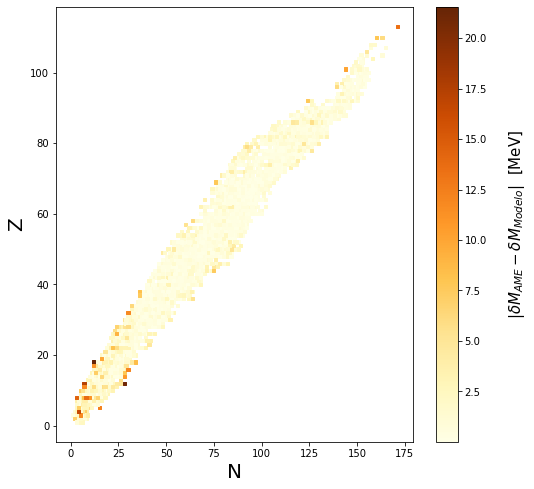

In [25]:
# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = PRED, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = abs(PRED-FULLDATAY), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFDIFF.png',dpi = 500)
plt.show()

In [26]:
print("RMS del modelo: ", RMS(PRED,FULLDATAY), 'MeV')

RMS del modelo:  1.9561883939404634 MeV


# M11

In [40]:
# GridSearch
model11 = RandomForestRegressor()
hyperparam = {'n_estimators':[4000,3000]}
fitter = GridSearchCV(model11, hyperparam)

In [41]:
Y11= Y11.reshape(np.shape(X11)[0],)
fitter.fit(X11,Y11)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [4000, 3000]})

In [42]:
fitter.best_params_

{'n_estimators': 4000}

In [43]:
# Se entrena el modelo
model11 = RandomForestRegressor(n_estimators= 4000)
Y11 = Y11.reshape(np.shape(X11)[0],)
model11.fit(X11,Y11)

RandomForestRegressor(n_estimators=4000)

In [44]:
print("Coeficiente de determinación del modelo para los datos de training: ",model11.score(X11, Y11))
print("Coeficiente de determinación del modelo para los datos de test: ",model11.score(XT, YT))

Coeficiente de determinación del modelo para los datos de training:  0.999220522294168
Coeficiente de determinación del modelo para los datos de test:  0.06627401063495897


In [45]:
PRED11 = model11.predict(X11)
PREDFRDM = model11.predict(XT)

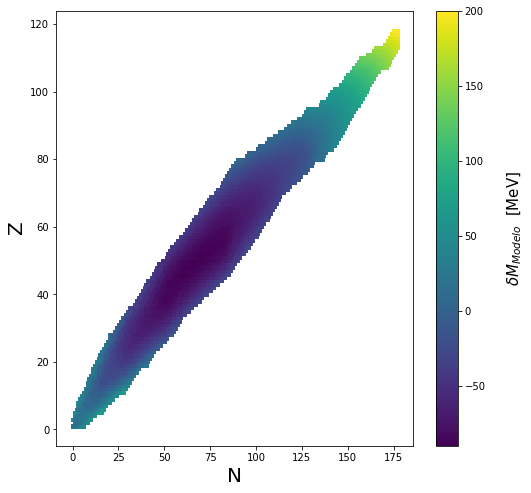

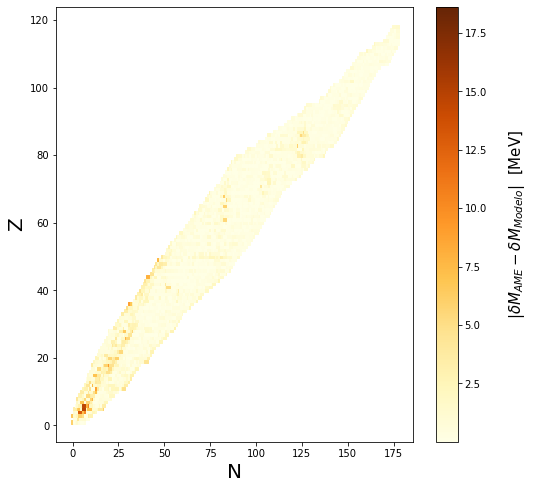

In [61]:
# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2],X11[:,1], c = PRED11, s = 10, marker=',')
#plt.scatter(XT[:,2],XT[:,1], c = PREDFRDM, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(X11[:,2], X11[:,1], c = abs(PRED11-Y11), s = 10, marker=',', cmap = 'YlOrBr')
#plt.scatter(np.concatenate((X11[:,2],XT[:,2])),np.concatenate((X11[:,1],XT[:,1])), c = abs(np.concatenate((PRED11,PREDFRDM))-np.concatenate((Y11,YT))), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M11RFDIFF.png',dpi = 500)
plt.show()

In [62]:
print("RMS del modelo: ", RMS(PRED11 ,Y11), 'MeV')

RMS del modelo:  1.512512903359871 MeV


# Modelo de Mixture Density Network (MDN)

### M12

In [11]:
import tensorflow as tf
from tensorflow import keras
import mdn

In [12]:
# Modelo de mixture density network
N_HIDDEN = 6  # number of hidden units in the Dense layer
N_MIXES = 30  # number of mixture components
OUTPUT_DIMS = 12  # number of real-values predicted by each mixture component

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam( learning_rate=0.001))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 12        
                                                                 
 mdn_2 (MDN)                 (None, 750)               5250      
                                                                 
Total params: 5,262
Trainable params: 5,262
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x=Y12TR, y=X12TR, batch_size=128, epochs=4000, validation_data=(Y12TE, X12TE))

Epoch 1/4000
14/14 [==============================] - 20s 265ms/step - loss: 22954721280.0000 - val_loss: 33480788.0000
Epoch 2/4000
14/14 [==============================] - 0s 10ms/step - loss: 177957184.0000 - val_loss: 1609000.3750
Epoch 3/4000
14/14 [==============================] - 0s 11ms/step - loss: 3749244.5000 - val_loss: 459212.4688
Epoch 4/4000
14/14 [==============================] - 0s 11ms/step - loss: 1408789.3750 - val_loss: 61602.5703
Epoch 5/4000
14/14 [==============================] - 0s 10ms/step - loss: 101440.4141 - val_loss: 48138.5703
Epoch 6/4000
14/14 [==============================] - 0s 10ms/step - loss: 93027.5234 - val_loss: 43400.9766
Epoch 7/4000
14/14 [==============================] - 0s 10ms/step - loss: 87779.6016 - val_loss: 39853.7812
Epoch 8/4000
14/14 [==============================] - 0s 10ms/step - loss: 82730.9531 - val_loss: 37172.8203
Epoch 9/4000
14/14 [==============================] - 0s 10ms/step - loss: 78959.8594 - val_loss: 34884.1

14/14 [==============================] - 0s 10ms/step - loss: 8239.6738 - val_loss: 2126.8726
Epoch 151/4000
14/14 [==============================] - 0s 10ms/step - loss: 8191.3076 - val_loss: 2107.5366
Epoch 152/4000
14/14 [==============================] - 0s 10ms/step - loss: 8131.0269 - val_loss: 2090.9304
Epoch 153/4000
14/14 [==============================] - 0s 10ms/step - loss: 8092.5938 - val_loss: 2072.7339
Epoch 154/4000
14/14 [==============================] - 0s 10ms/step - loss: 8023.2900 - val_loss: 2057.0913
Epoch 155/4000
14/14 [==============================] - 0s 10ms/step - loss: 7991.2817 - val_loss: 2038.2056
Epoch 156/4000
14/14 [==============================] - 0s 10ms/step - loss: 7924.3320 - val_loss: 2022.4998
Epoch 157/4000
14/14 [==============================] - 0s 10ms/step - loss: 7869.5864 - val_loss: 2006.7612
Epoch 158/4000
14/14 [==============================] - 0s 10ms/step - loss: 7824.3716 - val_loss: 1990.4801
Epoch 159/4000
14/14 [============

14/14 [==============================] - 0s 10ms/step - loss: 3904.0100 - val_loss: 863.2158
Epoch 301/4000
14/14 [==============================] - 0s 10ms/step - loss: 3887.9885 - val_loss: 859.7542
Epoch 302/4000
14/14 [==============================] - 0s 10ms/step - loss: 3877.3289 - val_loss: 855.3111
Epoch 303/4000
14/14 [==============================] - 0s 10ms/step - loss: 3859.1956 - val_loss: 851.1492
Epoch 304/4000
14/14 [==============================] - 0s 10ms/step - loss: 3842.9375 - val_loss: 847.0821
Epoch 305/4000
14/14 [==============================] - 0s 10ms/step - loss: 3828.3340 - val_loss: 843.1702
Epoch 306/4000
14/14 [==============================] - 0s 10ms/step - loss: 3811.9360 - val_loss: 839.6340
Epoch 307/4000
14/14 [==============================] - 0s 10ms/step - loss: 3798.8557 - val_loss: 835.6174
Epoch 308/4000
14/14 [==============================] - 0s 12ms/step - loss: 3783.4919 - val_loss: 831.7054
Epoch 309/4000
14/14 [=====================

14/14 [==============================] - 0s 10ms/step - loss: 2921.8772 - val_loss: 618.8411
Epoch 377/4000
14/14 [==============================] - 0s 10ms/step - loss: 2915.8987 - val_loss: 616.0343
Epoch 378/4000
14/14 [==============================] - 0s 10ms/step - loss: 2900.9260 - val_loss: 613.5325
Epoch 379/4000
14/14 [==============================] - 0s 10ms/step - loss: 2890.7498 - val_loss: 611.4016
Epoch 380/4000
14/14 [==============================] - 0s 10ms/step - loss: 2884.9973 - val_loss: 608.6653
Epoch 381/4000
14/14 [==============================] - 0s 10ms/step - loss: 2871.6267 - val_loss: 605.7215
Epoch 382/4000
14/14 [==============================] - 0s 10ms/step - loss: 2860.4475 - val_loss: 603.2612
Epoch 383/4000
14/14 [==============================] - 0s 12ms/step - loss: 2848.7117 - val_loss: 601.2520
Epoch 384/4000
14/14 [==============================] - 0s 10ms/step - loss: 2839.2974 - val_loss: 598.9984
Epoch 385/4000
14/14 [=====================

Epoch 452/4000
14/14 [==============================] - 0s 10ms/step - loss: 2240.0996 - val_loss: 459.0823
Epoch 453/4000
14/14 [==============================] - 0s 10ms/step - loss: 2232.3157 - val_loss: 457.6200
Epoch 454/4000
14/14 [==============================] - 0s 10ms/step - loss: 2228.3435 - val_loss: 455.5478
Epoch 455/4000
14/14 [==============================] - 0s 10ms/step - loss: 2218.1003 - val_loss: 453.7566
Epoch 456/4000
14/14 [==============================] - 0s 10ms/step - loss: 2210.1963 - val_loss: 452.1549
Epoch 457/4000
14/14 [==============================] - 0s 10ms/step - loss: 2203.1238 - val_loss: 450.4131
Epoch 458/4000
14/14 [==============================] - 0s 10ms/step - loss: 2195.6646 - val_loss: 448.8696
Epoch 459/4000
14/14 [==============================] - 0s 12ms/step - loss: 2188.1162 - val_loss: 447.2446
Epoch 460/4000
14/14 [==============================] - 0s 10ms/step - loss: 2180.8962 - val_loss: 445.5466
Epoch 461/4000
14/14 [======

Epoch 528/4000
14/14 [==============================] - 0s 10ms/step - loss: 1745.1675 - val_loss: 349.7151
Epoch 529/4000
14/14 [==============================] - 0s 10ms/step - loss: 1741.5184 - val_loss: 348.4593
Epoch 530/4000
14/14 [==============================] - 0s 10ms/step - loss: 1735.2911 - val_loss: 347.1817
Epoch 531/4000
14/14 [==============================] - 0s 10ms/step - loss: 1729.1393 - val_loss: 346.0298
Epoch 532/4000
14/14 [==============================] - 0s 10ms/step - loss: 1724.2126 - val_loss: 344.8675
Epoch 533/4000
14/14 [==============================] - 0s 10ms/step - loss: 1719.2222 - val_loss: 343.6502
Epoch 534/4000
14/14 [==============================] - 0s 10ms/step - loss: 1712.9683 - val_loss: 342.5437
Epoch 535/4000
14/14 [==============================] - 0s 10ms/step - loss: 1707.7043 - val_loss: 341.5070
Epoch 536/4000
14/14 [==============================] - 0s 10ms/step - loss: 1702.9486 - val_loss: 340.2879
Epoch 537/4000
14/14 [======

Epoch 604/4000
14/14 [==============================] - 0s 10ms/step - loss: 1382.1108 - val_loss: 273.0072
Epoch 605/4000
14/14 [==============================] - 0s 10ms/step - loss: 1378.1982 - val_loss: 272.1461
Epoch 606/4000
14/14 [==============================] - 0s 10ms/step - loss: 1373.6556 - val_loss: 271.4125
Epoch 607/4000
14/14 [==============================] - 0s 10ms/step - loss: 1371.5599 - val_loss: 270.3719
Epoch 608/4000
14/14 [==============================] - 0s 10ms/step - loss: 1365.5398 - val_loss: 269.6263
Epoch 609/4000
14/14 [==============================] - 0s 10ms/step - loss: 1362.0704 - val_loss: 268.7270
Epoch 610/4000
14/14 [==============================] - 0s 10ms/step - loss: 1357.7405 - val_loss: 267.9567
Epoch 611/4000
14/14 [==============================] - 0s 10ms/step - loss: 1354.2982 - val_loss: 267.0844
Epoch 612/4000
14/14 [==============================] - 0s 10ms/step - loss: 1350.2610 - val_loss: 266.2096
Epoch 613/4000
14/14 [======

Epoch 680/4000
14/14 [==============================] - 0s 10ms/step - loss: 1107.2301 - val_loss: 217.9832
Epoch 681/4000
14/14 [==============================] - 0s 10ms/step - loss: 1104.5303 - val_loss: 217.3771
Epoch 682/4000
14/14 [==============================] - 0s 10ms/step - loss: 1102.7241 - val_loss: 216.6756
Epoch 683/4000
14/14 [==============================] - 0s 10ms/step - loss: 1098.1653 - val_loss: 216.1380
Epoch 684/4000
14/14 [==============================] - 0s 10ms/step - loss: 1095.2637 - val_loss: 215.4963
Epoch 685/4000
14/14 [==============================] - 0s 10ms/step - loss: 1092.1235 - val_loss: 214.9243
Epoch 686/4000
14/14 [==============================] - 0s 10ms/step - loss: 1089.1726 - val_loss: 214.3282
Epoch 687/4000
14/14 [==============================] - 0s 10ms/step - loss: 1086.9651 - val_loss: 213.6722
Epoch 688/4000
14/14 [==============================] - 0s 10ms/step - loss: 1083.3557 - val_loss: 213.0663
Epoch 689/4000
14/14 [======

14/14 [==============================] - 0s 12ms/step - loss: 734.1443 - val_loss: 148.4545
Epoch 833/4000
14/14 [==============================] - 0s 10ms/step - loss: 732.4817 - val_loss: 148.1046
Epoch 834/4000
14/14 [==============================] - 0s 12ms/step - loss: 730.7313 - val_loss: 147.7938
Epoch 835/4000
14/14 [==============================] - 0s 10ms/step - loss: 728.7662 - val_loss: 147.4794
Epoch 836/4000
14/14 [==============================] - 0s 10ms/step - loss: 726.8054 - val_loss: 147.1706
Epoch 837/4000
14/14 [==============================] - 0s 12ms/step - loss: 725.7018 - val_loss: 146.8131
Epoch 838/4000
14/14 [==============================] - 0s 11ms/step - loss: 723.5988 - val_loss: 146.5088
Epoch 839/4000
14/14 [==============================] - 0s 12ms/step - loss: 721.7434 - val_loss: 146.2103
Epoch 840/4000
14/14 [==============================] - 0s 11ms/step - loss: 719.6744 - val_loss: 145.9057
Epoch 841/4000
14/14 [==============================

14/14 [==============================] - 0s 12ms/step - loss: 348.7225 - val_loss: 109.8063
Epoch 985/4000
14/14 [==============================] - 0s 10ms/step - loss: 347.2311 - val_loss: 109.6320
Epoch 986/4000
14/14 [==============================] - 0s 11ms/step - loss: 345.2183 - val_loss: 109.4667
Epoch 987/4000
14/14 [==============================] - 0s 10ms/step - loss: 343.4716 - val_loss: 109.3179
Epoch 988/4000
14/14 [==============================] - 0s 10ms/step - loss: 341.7100 - val_loss: 109.1526
Epoch 989/4000
14/14 [==============================] - 0s 10ms/step - loss: 339.8064 - val_loss: 109.0300
Epoch 990/4000
14/14 [==============================] - 0s 10ms/step - loss: 338.5037 - val_loss: 108.8874
Epoch 991/4000
14/14 [==============================] - 0s 10ms/step - loss: 336.6611 - val_loss: 108.7145
Epoch 992/4000
14/14 [==============================] - 0s 10ms/step - loss: 335.2003 - val_loss: 108.5581
Epoch 993/4000
14/14 [==============================

14/14 [==============================] - 0s 11ms/step - loss: 256.6439 - val_loss: 100.3872
Epoch 1061/4000
14/14 [==============================] - 0s 10ms/step - loss: 255.8522 - val_loss: 100.2771
Epoch 1062/4000
14/14 [==============================] - 0s 11ms/step - loss: 255.0652 - val_loss: 100.1687
Epoch 1063/4000
14/14 [==============================] - 0s 10ms/step - loss: 254.1790 - val_loss: 100.0698
Epoch 1064/4000
14/14 [==============================] - 0s 10ms/step - loss: 253.2722 - val_loss: 99.9795
Epoch 1065/4000
14/14 [==============================] - 0s 10ms/step - loss: 252.8061 - val_loss: 99.8861
Epoch 1066/4000
14/14 [==============================] - 0s 11ms/step - loss: 251.6387 - val_loss: 99.7881
Epoch 1067/4000
14/14 [==============================] - 0s 11ms/step - loss: 250.9254 - val_loss: 99.6861
Epoch 1068/4000
14/14 [==============================] - 0s 10ms/step - loss: 250.1436 - val_loss: 99.5972
Epoch 1069/4000
14/14 [==========================

Epoch 1213/4000
14/14 [==============================] - 0s 12ms/step - loss: 174.2111 - val_loss: 85.1283
Epoch 1214/4000
14/14 [==============================] - 0s 10ms/step - loss: 173.8149 - val_loss: 85.0428
Epoch 1215/4000
14/14 [==============================] - 0s 11ms/step - loss: 173.5240 - val_loss: 84.9806
Epoch 1216/4000
14/14 [==============================] - 0s 11ms/step - loss: 173.1322 - val_loss: 84.8834
Epoch 1217/4000
14/14 [==============================] - 0s 13ms/step - loss: 172.7613 - val_loss: 84.8146
Epoch 1218/4000
14/14 [==============================] - 0s 10ms/step - loss: 172.4966 - val_loss: 84.7321
Epoch 1219/4000
14/14 [==============================] - 0s 12ms/step - loss: 172.1172 - val_loss: 84.6647
Epoch 1220/4000
14/14 [==============================] - 0s 12ms/step - loss: 171.8204 - val_loss: 84.5691
Epoch 1221/4000
14/14 [==============================] - 0s 10ms/step - loss: 171.4221 - val_loss: 84.4988
Epoch 1222/4000
14/14 [==============

14/14 [==============================] - 0s 10ms/step - loss: 133.1261 - val_loss: 74.7407
Epoch 1366/4000
14/14 [==============================] - 0s 10ms/step - loss: 132.8961 - val_loss: 74.6876
Epoch 1367/4000
14/14 [==============================] - 0s 10ms/step - loss: 132.7240 - val_loss: 74.6177
Epoch 1368/4000
14/14 [==============================] - 0s 10ms/step - loss: 132.4948 - val_loss: 74.5614
Epoch 1369/4000
14/14 [==============================] - 0s 10ms/step - loss: 132.2877 - val_loss: 74.5054
Epoch 1370/4000
14/14 [==============================] - 0s 10ms/step - loss: 132.1467 - val_loss: 74.4365
Epoch 1371/4000
14/14 [==============================] - 0s 10ms/step - loss: 131.8689 - val_loss: 74.3709
Epoch 1372/4000
14/14 [==============================] - 0s 10ms/step - loss: 131.6720 - val_loss: 74.3111
Epoch 1373/4000
14/14 [==============================] - 0s 10ms/step - loss: 131.4703 - val_loss: 74.2653
Epoch 1374/4000
14/14 [==============================

14/14 [==============================] - 0s 10ms/step - loss: 106.5873 - val_loss: 66.6446
Epoch 1518/4000
14/14 [==============================] - 0s 10ms/step - loss: 106.4788 - val_loss: 66.5849
Epoch 1519/4000
14/14 [==============================] - 0s 11ms/step - loss: 106.3330 - val_loss: 66.5570
Epoch 1520/4000
14/14 [==============================] - 0s 10ms/step - loss: 106.1771 - val_loss: 66.5027
Epoch 1521/4000
14/14 [==============================] - 0s 10ms/step - loss: 106.0348 - val_loss: 66.4621
Epoch 1522/4000
14/14 [==============================] - 0s 10ms/step - loss: 105.8699 - val_loss: 66.4098
Epoch 1523/4000
14/14 [==============================] - 0s 10ms/step - loss: 105.7611 - val_loss: 66.3796
Epoch 1524/4000
14/14 [==============================] - 0s 10ms/step - loss: 105.5668 - val_loss: 66.3320
Epoch 1525/4000
14/14 [==============================] - 0s 10ms/step - loss: 105.4753 - val_loss: 66.2768
Epoch 1526/4000
14/14 [==============================

Epoch 1594/4000
14/14 [==============================] - 0s 10ms/step - loss: 96.5675 - val_loss: 63.4603
Epoch 1595/4000
14/14 [==============================] - 0s 10ms/step - loss: 96.4652 - val_loss: 63.4210
Epoch 1596/4000
14/14 [==============================] - 0s 10ms/step - loss: 96.3844 - val_loss: 63.3801
Epoch 1597/4000
14/14 [==============================] - 0s 11ms/step - loss: 96.2274 - val_loss: 63.3428
Epoch 1598/4000
14/14 [==============================] - 0s 10ms/step - loss: 96.1168 - val_loss: 63.3062
Epoch 1599/4000
14/14 [==============================] - 0s 10ms/step - loss: 96.0374 - val_loss: 63.2675
Epoch 1600/4000
14/14 [==============================] - 0s 10ms/step - loss: 95.9225 - val_loss: 63.2378
Epoch 1601/4000
14/14 [==============================] - 0s 10ms/step - loss: 95.7727 - val_loss: 63.1974
Epoch 1602/4000
14/14 [==============================] - 0s 10ms/step - loss: 95.6610 - val_loss: 63.1680
Epoch 1603/4000
14/14 [=======================

14/14 [==============================] - 0s 10ms/step - loss: 81.8994 - val_loss: 58.7033
Epoch 1749/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.8200 - val_loss: 58.6747
Epoch 1750/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.7728 - val_loss: 58.6513
Epoch 1751/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.6518 - val_loss: 58.6151
Epoch 1752/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.5822 - val_loss: 58.5970
Epoch 1753/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.5110 - val_loss: 58.5676
Epoch 1754/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.4181 - val_loss: 58.5559
Epoch 1755/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.3595 - val_loss: 58.5198
Epoch 1756/4000
14/14 [==============================] - 0s 10ms/step - loss: 81.2651 - val_loss: 58.4932
Epoch 1757/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 11ms/step - loss: 71.9814 - val_loss: 55.4634
Epoch 1903/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.9316 - val_loss: 55.4383
Epoch 1904/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.8849 - val_loss: 55.4262
Epoch 1905/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.8242 - val_loss: 55.4071
Epoch 1906/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.7726 - val_loss: 55.4018
Epoch 1907/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.7360 - val_loss: 55.3938
Epoch 1908/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.6772 - val_loss: 55.3594
Epoch 1909/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.6197 - val_loss: 55.3408
Epoch 1910/4000
14/14 [==============================] - 0s 10ms/step - loss: 71.5792 - val_loss: 55.3230
Epoch 1911/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 15ms/step - loss: 65.2698 - val_loss: 53.2481
Epoch 2057/4000
14/14 [==============================] - 0s 12ms/step - loss: 65.2275 - val_loss: 53.2454
Epoch 2058/4000
14/14 [==============================] - 0s 11ms/step - loss: 65.1795 - val_loss: 53.2247
Epoch 2059/4000
14/14 [==============================] - 0s 13ms/step - loss: 65.1498 - val_loss: 53.2073
Epoch 2060/4000
14/14 [==============================] - 0s 14ms/step - loss: 65.1049 - val_loss: 53.1862
Epoch 2061/4000
14/14 [==============================] - 0s 10ms/step - loss: 65.0740 - val_loss: 53.1737
Epoch 2062/4000
14/14 [==============================] - 0s 14ms/step - loss: 65.0526 - val_loss: 53.1764
Epoch 2063/4000
14/14 [==============================] - 0s 12ms/step - loss: 65.0059 - val_loss: 53.1521
Epoch 2064/4000
14/14 [==============================] - 0s 11ms/step - loss: 64.9684 - val_loss: 53.1431
Epoch 2065/4000
14/14 [==============================] - 0s 13

14/14 [==============================] - 0s 11ms/step - loss: 60.5449 - val_loss: 51.6603
Epoch 2211/4000
14/14 [==============================] - 0s 17ms/step - loss: 60.5269 - val_loss: 51.6216
Epoch 2212/4000
14/14 [==============================] - 0s 14ms/step - loss: 60.5014 - val_loss: 51.6279
Epoch 2213/4000
14/14 [==============================] - 0s 11ms/step - loss: 60.4693 - val_loss: 51.6151
Epoch 2214/4000
14/14 [==============================] - 0s 16ms/step - loss: 60.4396 - val_loss: 51.6100
Epoch 2215/4000
14/14 [==============================] - 0s 14ms/step - loss: 60.4111 - val_loss: 51.5983
Epoch 2216/4000
14/14 [==============================] - 0s 15ms/step - loss: 60.3936 - val_loss: 51.5948
Epoch 2217/4000
14/14 [==============================] - 0s 10ms/step - loss: 60.3595 - val_loss: 51.5702
Epoch 2218/4000
14/14 [==============================] - 0s 10ms/step - loss: 60.3342 - val_loss: 51.5564
Epoch 2219/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 12ms/step - loss: 57.1729 - val_loss: 50.4833
Epoch 2365/4000
14/14 [==============================] - 0s 13ms/step - loss: 57.1596 - val_loss: 50.4822
Epoch 2366/4000
14/14 [==============================] - 0s 10ms/step - loss: 57.1540 - val_loss: 50.4897
Epoch 2367/4000
14/14 [==============================] - 0s 13ms/step - loss: 57.1329 - val_loss: 50.4704
Epoch 2368/4000
14/14 [==============================] - 0s 10ms/step - loss: 57.1115 - val_loss: 50.4575
Epoch 2369/4000
14/14 [==============================] - 0s 11ms/step - loss: 57.0964 - val_loss: 50.4591
Epoch 2370/4000
14/14 [==============================] - 0s 11ms/step - loss: 57.0798 - val_loss: 50.4598
Epoch 2371/4000
14/14 [==============================] - 0s 11ms/step - loss: 57.0480 - val_loss: 50.4421
Epoch 2372/4000
14/14 [==============================] - 0s 14ms/step - loss: 57.0380 - val_loss: 50.4356
Epoch 2373/4000
14/14 [==============================] - 0s 11

14/14 [==============================] - 0s 11ms/step - loss: 54.6866 - val_loss: 49.6153
Epoch 2519/4000
14/14 [==============================] - 0s 10ms/step - loss: 54.6798 - val_loss: 49.6187
Epoch 2520/4000
14/14 [==============================] - 0s 10ms/step - loss: 54.6557 - val_loss: 49.6000
Epoch 2521/4000
14/14 [==============================] - 0s 11ms/step - loss: 54.6295 - val_loss: 49.6019
Epoch 2522/4000
14/14 [==============================] - 0s 10ms/step - loss: 54.6253 - val_loss: 49.5886
Epoch 2523/4000
14/14 [==============================] - 0s 10ms/step - loss: 54.6133 - val_loss: 49.5857
Epoch 2524/4000
14/14 [==============================] - 0s 10ms/step - loss: 54.5990 - val_loss: 49.5920
Epoch 2525/4000
14/14 [==============================] - 0s 11ms/step - loss: 54.5787 - val_loss: 49.5803
Epoch 2526/4000
14/14 [==============================] - 0s 10ms/step - loss: 54.5719 - val_loss: 49.5698
Epoch 2527/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 13ms/step - loss: 52.7900 - val_loss: 48.9454
Epoch 2673/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7723 - val_loss: 48.9524
Epoch 2674/4000
14/14 [==============================] - 0s 11ms/step - loss: 52.7665 - val_loss: 48.9381
Epoch 2675/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7569 - val_loss: 48.9464
Epoch 2676/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7404 - val_loss: 48.9244
Epoch 2677/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7282 - val_loss: 48.9252
Epoch 2678/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7273 - val_loss: 48.9348
Epoch 2679/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7119 - val_loss: 48.9213
Epoch 2680/4000
14/14 [==============================] - 0s 10ms/step - loss: 52.7007 - val_loss: 48.9149
Epoch 2681/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 10ms/step - loss: 51.3168 - val_loss: 48.4259
Epoch 2827/4000
14/14 [==============================] - 0s 10ms/step - loss: 51.3096 - val_loss: 48.4099
Epoch 2828/4000
14/14 [==============================] - 0s 10ms/step - loss: 51.3019 - val_loss: 48.4156
Epoch 2829/4000
14/14 [==============================] - 0s 13ms/step - loss: 51.2943 - val_loss: 48.4127
Epoch 2830/4000
14/14 [==============================] - 0s 11ms/step - loss: 51.2836 - val_loss: 48.4164
Epoch 2831/4000
14/14 [==============================] - 0s 10ms/step - loss: 51.2744 - val_loss: 48.3999
Epoch 2832/4000
14/14 [==============================] - 0s 10ms/step - loss: 51.2662 - val_loss: 48.4023
Epoch 2833/4000
14/14 [==============================] - 0s 10ms/step - loss: 51.2563 - val_loss: 48.3898
Epoch 2834/4000
14/14 [==============================] - 0s 11ms/step - loss: 51.2488 - val_loss: 48.3891
Epoch 2835/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 11ms/step - loss: 50.1136 - val_loss: 47.9652
Epoch 2981/4000
14/14 [==============================] - 0s 11ms/step - loss: 50.1022 - val_loss: 47.9610
Epoch 2982/4000
14/14 [==============================] - 0s 13ms/step - loss: 50.0904 - val_loss: 47.9629
Epoch 2983/4000
14/14 [==============================] - 0s 14ms/step - loss: 50.0771 - val_loss: 47.9555
Epoch 2984/4000
14/14 [==============================] - 0s 14ms/step - loss: 50.0724 - val_loss: 47.9542
Epoch 2985/4000
14/14 [==============================] - 0s 10ms/step - loss: 50.0677 - val_loss: 47.9444
Epoch 2986/4000
14/14 [==============================] - 0s 10ms/step - loss: 50.0568 - val_loss: 47.9471
Epoch 2987/4000
14/14 [==============================] - 0s 14ms/step - loss: 50.0490 - val_loss: 47.9463
Epoch 2988/4000
14/14 [==============================] - 0s 16ms/step - loss: 50.0477 - val_loss: 47.9473
Epoch 2989/4000
14/14 [==============================] - 0s 11

14/14 [==============================] - 0s 11ms/step - loss: 48.5491 - val_loss: 47.1324
Epoch 3135/4000
14/14 [==============================] - 0s 10ms/step - loss: 48.5366 - val_loss: 47.1232
Epoch 3136/4000
14/14 [==============================] - 0s 10ms/step - loss: 48.5241 - val_loss: 47.1188
Epoch 3137/4000
14/14 [==============================] - 0s 11ms/step - loss: 48.5156 - val_loss: 47.1088
Epoch 3138/4000
14/14 [==============================] - 0s 12ms/step - loss: 48.5060 - val_loss: 47.1002
Epoch 3139/4000
14/14 [==============================] - 0s 10ms/step - loss: 48.4999 - val_loss: 47.1065
Epoch 3140/4000
14/14 [==============================] - 0s 10ms/step - loss: 48.5007 - val_loss: 47.1069
Epoch 3141/4000
14/14 [==============================] - 0s 10ms/step - loss: 48.4921 - val_loss: 47.0906
Epoch 3142/4000
14/14 [==============================] - 0s 10ms/step - loss: 48.4790 - val_loss: 47.0774
Epoch 3143/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 11ms/step - loss: 47.4675 - val_loss: 46.5654
Epoch 3289/4000
14/14 [==============================] - 0s 13ms/step - loss: 47.4687 - val_loss: 46.5846
Epoch 3290/4000
14/14 [==============================] - 0s 11ms/step - loss: 47.4646 - val_loss: 46.5614
Epoch 3291/4000
14/14 [==============================] - 0s 11ms/step - loss: 47.4550 - val_loss: 46.5645
Epoch 3292/4000
14/14 [==============================] - 0s 13ms/step - loss: 47.4514 - val_loss: 46.5688
Epoch 3293/4000
14/14 [==============================] - 0s 11ms/step - loss: 47.4536 - val_loss: 46.5555
Epoch 3294/4000
14/14 [==============================] - 0s 13ms/step - loss: 47.4410 - val_loss: 46.5563
Epoch 3295/4000
14/14 [==============================] - 0s 15ms/step - loss: 47.4264 - val_loss: 46.5478
Epoch 3296/4000
14/14 [==============================] - 0s 11ms/step - loss: 47.4315 - val_loss: 46.5538
Epoch 3297/4000
14/14 [==============================] - 0s 13

14/14 [==============================] - 0s 10ms/step - loss: 46.8979 - val_loss: 46.3320
Epoch 3443/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.9025 - val_loss: 46.3330
Epoch 3444/4000
14/14 [==============================] - 0s 13ms/step - loss: 46.8890 - val_loss: 46.3386
Epoch 3445/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.8815 - val_loss: 46.3214
Epoch 3446/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.8801 - val_loss: 46.3344
Epoch 3447/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.8891 - val_loss: 46.3320
Epoch 3448/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.8869 - val_loss: 46.3242
Epoch 3449/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.8771 - val_loss: 46.3342
Epoch 3450/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.8734 - val_loss: 46.3240
Epoch 3451/4000
14/14 [==============================] - 0s 10

14/14 [==============================] - 0s 11ms/step - loss: 46.5508 - val_loss: 46.2080
Epoch 3597/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5438 - val_loss: 46.2189
Epoch 3598/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5397 - val_loss: 46.2103
Epoch 3599/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5366 - val_loss: 46.2097
Epoch 3600/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5382 - val_loss: 46.2017
Epoch 3601/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5389 - val_loss: 46.2049
Epoch 3602/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5320 - val_loss: 46.2020
Epoch 3603/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5236 - val_loss: 46.1963
Epoch 3604/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.5329 - val_loss: 46.1990
Epoch 3605/4000
14/14 [==============================] - 0s 12

14/14 [==============================] - 0s 10ms/step - loss: 46.3179 - val_loss: 46.1378
Epoch 3751/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.3221 - val_loss: 46.1418
Epoch 3752/4000
14/14 [==============================] - 0s 12ms/step - loss: 46.3230 - val_loss: 46.1379
Epoch 3753/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.3396 - val_loss: 46.1539
Epoch 3754/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.3330 - val_loss: 46.1545
Epoch 3755/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.3277 - val_loss: 46.1381
Epoch 3756/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.3178 - val_loss: 46.1428
Epoch 3757/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.3132 - val_loss: 46.1373
Epoch 3758/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.3123 - val_loss: 46.1379
Epoch 3759/4000
14/14 [==============================] - 0s 11

14/14 [==============================] - 0s 11ms/step - loss: 46.1662 - val_loss: 46.0820
Epoch 3905/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.1572 - val_loss: 46.0842
Epoch 3906/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.1648 - val_loss: 46.1082
Epoch 3907/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.1676 - val_loss: 46.0847
Epoch 3908/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.1574 - val_loss: 46.0865
Epoch 3909/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.1522 - val_loss: 46.0793
Epoch 3910/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.1571 - val_loss: 46.0979
Epoch 3911/4000
14/14 [==============================] - 0s 10ms/step - loss: 46.1578 - val_loss: 46.0837
Epoch 3912/4000
14/14 [==============================] - 0s 11ms/step - loss: 46.1516 - val_loss: 46.0809
Epoch 3913/4000
14/14 [==============================] - 0s 11

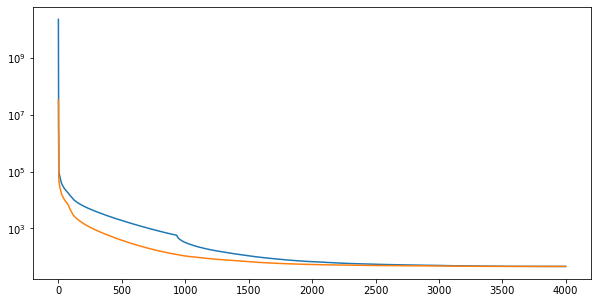

In [15]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.show()

In [16]:
y_test = model.predict(Y12TR)
# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, y_test)
# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, OUTPUT_DIMS, N_MIXES, temp=1.0, sigma_temp=1.0)

55/55 [==============================] - 0s 2ms/step


In [22]:
print(pis)
print(pis.shape)

print(mus)
print(mus.shape)

print(sigs)
print(sigs.shape)

[[1.93288920e-22 1.96278671e-24 4.34663345e-24 ... 2.02849958e-26
  3.47492612e-26 1.09040576e-26]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.84468114e-19 5.56883419e-23 4.58253061e-22 ... 3.86519598e-23
  1.30040959e-24 4.59716344e-24]
 ...
 [4.97578007e-18 2.77639331e-22 4.29123369e-21 ... 1.45316216e-21
  7.40530395e-24 8.37605757e-23]
 [6.97413746e-20 3.46567769e-23 2.36762931e-22 ... 1.32485513e-23
  7.78137919e-25 1.95146853e-24]
 [5.97206370e-18 3.03478905e-22 4.85730230e-21 ... 1.77650284e-21
  8.15435341e-24 9.83708287e-23]]
(1752, 30)
[[-1.9503604   1.274455    1.8836957  ...  0.7980299   2.3251553
   0.90140665]
 [ 8.150332   -2.4731798   6.896531   ...  7.894319   -2.0702689
   2.2277339 ]
 [-1.7328025   1.268168    2.1163776  ...  0.47994208  1.944426
   0.77628124]
 ...
 [-1.6283253   1.2651488   2.2281177  ...  0.3271878   1.7615895
   0.7161927 ]
 [-1.7636455   1.2690593   2.0833907  ...  0.52503705  1.9984016


In [23]:
print(y_test)
print(y_test.shape)

[[  -1.9503604    1.274455     1.8836957 ...  -25.829788   -25.291512
   -26.450533 ]
 [   8.150332    -2.4731798    6.896531  ... -282.0548     -94.90956
  -141.66823  ]
 [  -1.7328025    1.268168     2.1163776 ...  -19.56302    -22.954937
   -21.692175 ]
 ...
 [  -1.6283253    1.2651488    2.2281177 ...  -16.55355    -21.83285
   -19.407084 ]
 [  -1.7636455    1.2690593    2.0833907 ...  -20.451454   -23.286192
   -22.366762 ]
 [  -1.6225381    1.2649816    2.2343078 ...  -16.386845   -21.770695
   -19.280502 ]]
(1752, 750)


/home/alejandro/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


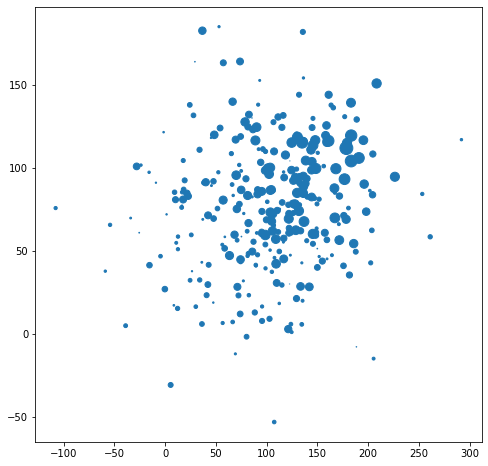

In [24]:
# Plot the predicted samples.
fig = plt.figure(figsize = (8,8))
plt.scatter(y_samples[:,:,2], y_samples[:,:,1], Y12TR) #c=perf_down_sampled.moving
plt.show()

In [65]:
# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = y_test, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFPRED.png',dpi = 500)
plt.show()


# Diferencias
fig = plt.figure(figsize = (8,8))
plt.scatter(FULLDATA12[:,2],FULLDATA12[:,1], c = abs(y_test-FULLDATAY), s = 10, marker=',', cmap = 'YlOrBr')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='|$\delta M_{AME}-\delta M_{Modelo}$|  [MeV]', size=15, labelpad=20)
plt.savefig('M12RFDIFF.png',dpi = 500)
plt.show()

NameError: name 'FULLDATA12' is not defined

<Figure size 576x576 with 0 Axes>

In [37]:
y_test = model.predict(Y12TR)
y_test

55/55 [==============================] - 0s 2ms/step


array([[ 2.2140244e+01,  1.8528263e+01, -4.3412665e-01, ...,
        -9.8525864e+01, -1.0215972e+02, -1.4558823e+01],
       [ 4.3176401e+02,  4.2125354e+02,  5.0673657e+02, ...,
        -3.1982291e+02, -3.5289948e+02, -2.6532269e+02],
       [ 2.1633625e+01,  2.0538580e+01, -8.5696942e-01, ...,
        -9.3901749e+01, -1.1079036e+02, -1.0365503e+01],
       ...,
       [ 2.1390331e+01,  2.1503986e+01, -1.0600297e+00, ...,
        -9.1681129e+01, -1.1493503e+02, -8.3517590e+00],
       [ 2.1705448e+01,  2.0253580e+01, -7.9702336e-01, ...,
        -9.4557304e+01, -1.0956681e+02, -1.0959985e+01],
       [ 2.1376856e+01,  2.1557465e+01, -1.0712781e+00, ...,
        -9.1558113e+01, -1.1516461e+02, -8.2402077e+00]], dtype=float32)

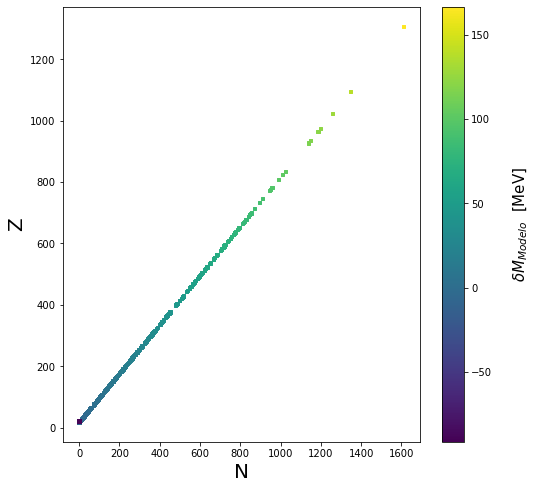

In [42]:
# Predicciones del modelo
fig = plt.figure(figsize = (8,8))
plt.scatter(y_test[:,2],y_test[:,1], c = Y12TR, s = 10, marker=',')
plt.xlabel('N', fontsize= 20)
plt.ylabel('Z', fontsize= 20)
plt.colorbar().set_label(label='$\delta M_{Modelo}$  [MeV]', size=15, labelpad=20)
plt.show()